# Data augmentation

## Imports

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from IPython.display import clear_output

## Reading statistics

In [12]:
#stats_file = "image_dimensions.csv"
stats_file = "/kaggle/input/image-dimensions/image_dimensions.csv"
stats = pd.read_csv(stats_file)
stats.set_index("Unnamed: 0", inplace=True)
stats.index.name = None
stats

,widths,heights
count,2797.000000,2797.000000
mean,603.319271,648.314623
std,415.975788,446.883172
min,106.000000,108.000000
25%,314.000000,383.000000
50%,550.000000,590.000000
75%,800.000000,826.000000
max,7264.000000,6017.000000
median,550.000000,590.000000


## Helper functions

In [13]:
width = int(stats.loc["median", "widths"])
height = int(stats.loc["median", "heights"])

def build_model(width, height, data_augmentation=None):
    model = keras.Sequential()
    model.add(layers.InputLayer(shape=(width, height, 3)))

    if data_augmentation:
        model.add(data_augmentation)

    model.add(layers.Rescaling(1./255))
    model.add(layers.Conv2D(32, 3, activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.Conv2D(64, 3, activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.Conv2D(128, 3, activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.Conv2D(256, 3, activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.Conv2D(256, 3, activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

model = build_model(width, height)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 550, 590, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 548, 588, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 274, 294, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 272, 292, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 136, 146, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 134, 144, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 67, 72, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 65, 70, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 32, 35, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 30, 33, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 253440)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │         253,441 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,231,937 (4.70 MB)

 Trainable params: 1,231,937 (4.70 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
def load_dataset(base_dir, painters, width, height, batch_size=16, interpolation="bilinear"):
    train_dataset = image_dataset_from_directory(
        f'{base_dir}/train',
        labels='inferred',
        label_mode='int',
        class_names=painters,
        image_size=(width, height),
        batch_size=batch_size,
        interpolation=interpolation
    )
    validation_dataset = image_dataset_from_directory(
        f'{base_dir}/validation',
        labels='inferred',
        label_mode='int',
        class_names=painters,
        image_size=(width, height),
        batch_size=batch_size,
        interpolation=interpolation
    )
    test_dataset = image_dataset_from_directory(
        f'{base_dir}/test',
        labels='inferred',
        label_mode='int',
        class_names=painters,
        image_size=(width, height),
        batch_size=batch_size,
        interpolation=interpolation
    )
    return train_dataset, validation_dataset, test_dataset

In [15]:
def print_metrics(model, test):
    test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test, verbose=0)

    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {test_accuracy}")
    print(f"Test Precision: {test_precision}")
    print(f"Test Recall: {test_recall}")

In [16]:
def display_augmentation(data, data_augmentation):
    for images, _ in data.take(1):
        for i in range(9):
            augmented_images = data_augmentation(images)
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(augmented_images[0].numpy().astype("uint8"))
            plt.axis("off")

In [17]:
class DynamicMetricsPlotCallback(Callback):
    def __init__(self):
        super().__init__()
        self.history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}
       
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        for metric in self.history.keys():
            if metric in logs:
                self.history[metric].append(logs[metric])
       
        clear_output(wait=True)
        plt.figure(figsize=(12, 4))
       
        # Loss plot
        plt.subplot(1, 2, 1)
        plt.plot(self.history['loss'], label='Training Loss')
        plt.plot(self.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
       
        # Accuracy plot
        plt.subplot(1, 2, 2)
        plt.plot(self.history['accuracy'], label='Training Accuracy')
        plt.plot(self.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)
       
        plt.tight_layout()
        plt.show()

## Data augmentation

### Base model

In [18]:
painters = ["Mondriaan", "Picasso"]
#dataset_dir = "undersampled_dataset"
dataset_dir = "/kaggle/input/schilderijen-datasets/undersampled_dataset"
train, val, test = load_dataset(dataset_dir, painters, width, height)

Found 310 files belonging to 2 classes.
Found 102 files belonging to 2 classes.
Found 102 files belonging to 2 classes.


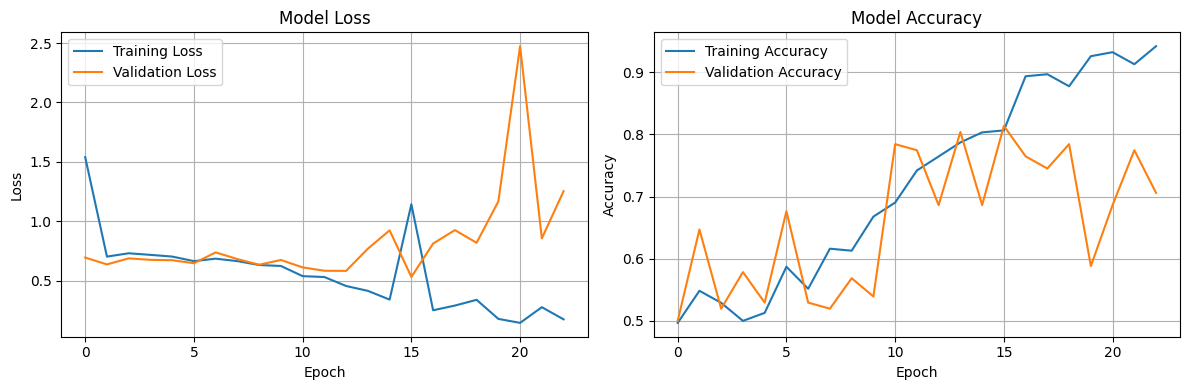

In [19]:
callbacks = [ModelCheckpoint(filepath="model_undersampled.keras", save_best_only=True, monitor="val_loss"), DynamicMetricsPlotCallback()
            ,EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)]
model = build_model(width, height)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy", keras.metrics.Precision(), keras.metrics.Recall()])
history = model.fit(train, epochs=50, validation_data=val, callbacks=callbacks, verbose=0)

In [20]:
print_metrics(model, test)

Test Loss: 0.753633439540863
Test Accuracy: 0.7450980544090271
Test Precision: 0.8571428656578064
Test Recall: 0.5882353186607361


### Randomflip

In [21]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomFlip("vertical"),
])

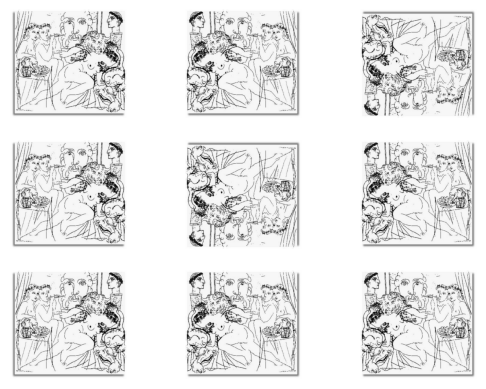

In [22]:
display_augmentation(train, data_augmentation)

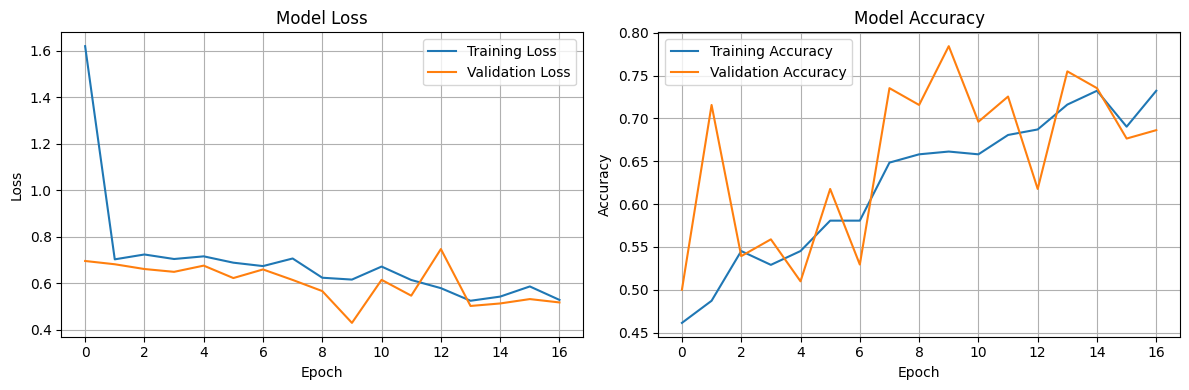

In [23]:
callbacks = [ModelCheckpoint(filepath="model_undersampled.keras", save_best_only=True, monitor="val_loss"), DynamicMetricsPlotCallback()
            ,EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)]
model = build_model(width, height, data_augmentation)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy", keras.metrics.Precision(), keras.metrics.Recall()])
history = model.fit(train, epochs=50, validation_data=val, callbacks=callbacks, verbose=0)

In [24]:
print_metrics(model, test)

Test Loss: 0.53993159532547
Test Accuracy: 0.6960784196853638
Test Precision: 0.7083333134651184
Test Recall: 0.6666666865348816


### RandomTranslation

In [25]:
data_augmentation = keras.Sequential([
    layers.RandomTranslation(0.3, 0.3),
])

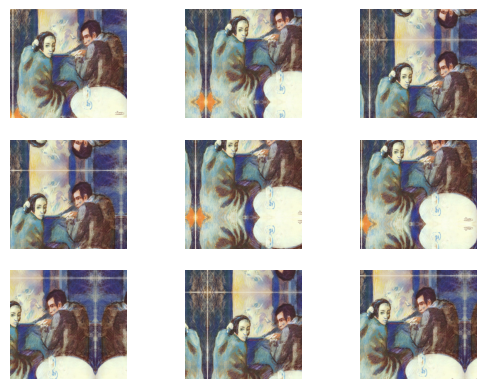

In [26]:
display_augmentation(train, data_augmentation)

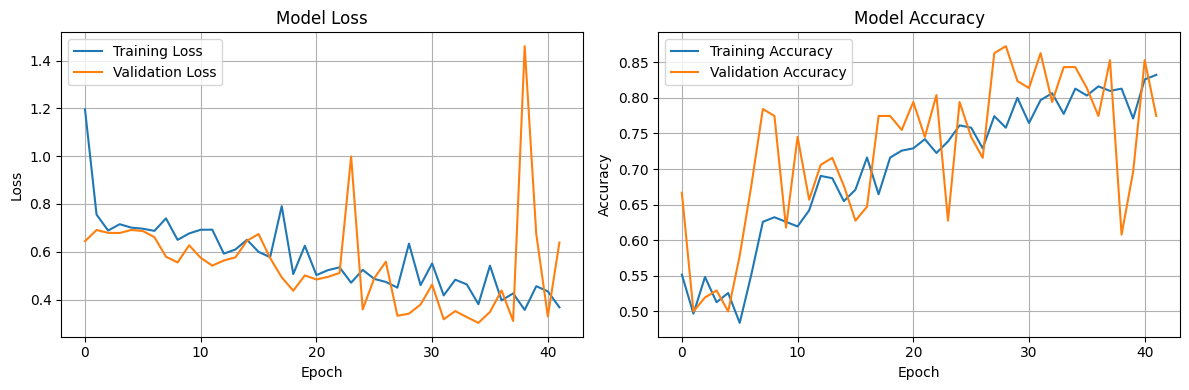

In [27]:
callbacks = [ModelCheckpoint(filepath="model_undersampled.keras", save_best_only=True, monitor="val_loss"), DynamicMetricsPlotCallback()
            ,EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)]
model = build_model(width, height, data_augmentation)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy", keras.metrics.Precision(), keras.metrics.Recall()])
history = model.fit(train, epochs=50, validation_data=val, callbacks=callbacks, verbose=0)

In [28]:
print_metrics(model, test)

Test Loss: 0.24945972859859467
Test Accuracy: 0.8725489974021912
Test Precision: 0.9130434989929199
Test Recall: 0.8235294222831726


### RandomZoom

In [29]:
data_augmentation = keras.Sequential([
    layers.RandomZoom(0.3),
])

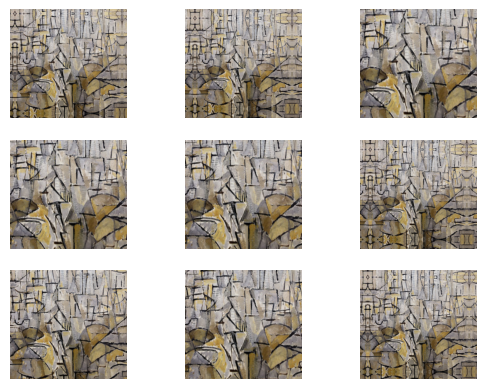

In [30]:
display_augmentation(train, data_augmentation)

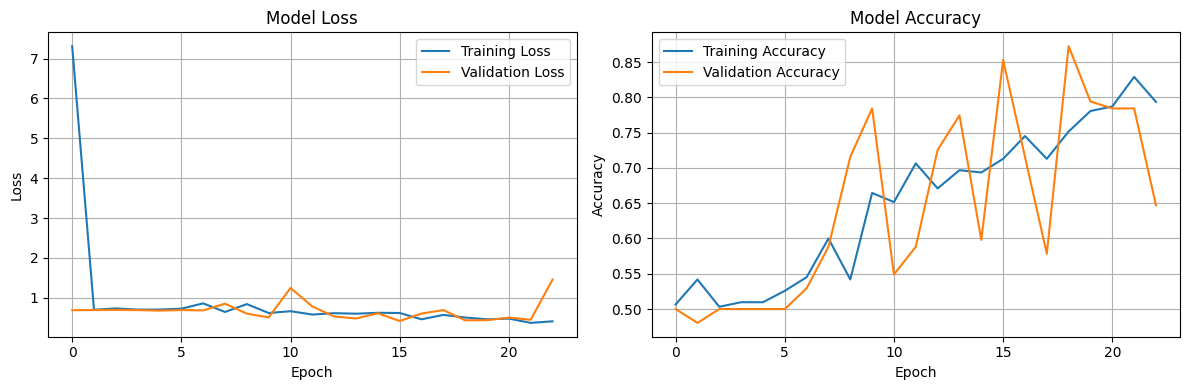

In [31]:
callbacks = [ModelCheckpoint(filepath="model_undersampled.keras", save_best_only=True, monitor="val_loss"), DynamicMetricsPlotCallback()
            ,EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)]
model = build_model(width, height, data_augmentation)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy", keras.metrics.Precision(), keras.metrics.Recall()])
history = model.fit(train, epochs=50, validation_data=val, callbacks=callbacks, verbose=0)

In [32]:
print_metrics(model, test)

Test Loss: 0.48279061913490295
Test Accuracy: 0.7941176295280457
Test Precision: 0.8260869383811951
Test Recall: 0.7450980544090271


### RandomContrast

In [33]:
data_augmentation = keras.Sequential([
    layers.RandomContrast(0.3),
])

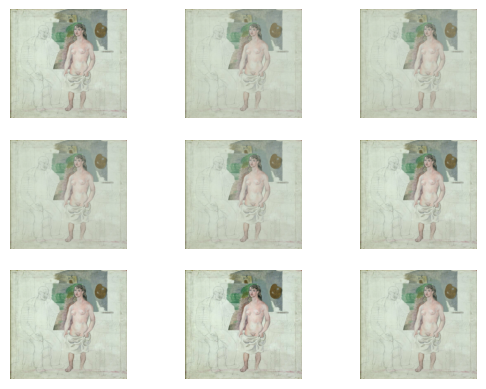

In [34]:
display_augmentation(train, data_augmentation)

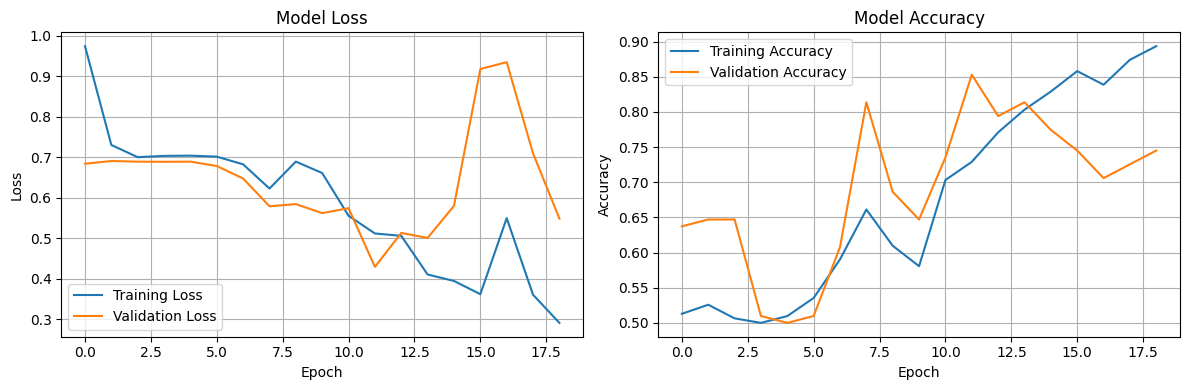

In [35]:
callbacks = [ModelCheckpoint(filepath="model_undersampled.keras", save_best_only=True, monitor="val_loss"), DynamicMetricsPlotCallback()
            ,EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)]
model = build_model(width, height, data_augmentation)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy", keras.metrics.Precision(), keras.metrics.Recall()])
history = model.fit(train, epochs=50, validation_data=val, callbacks=callbacks, verbose=0)

In [36]:
print_metrics(model, test)

Test Loss: 0.6379122734069824
Test Accuracy: 0.813725471496582
Test Precision: 0.8333333134651184
Test Recall: 0.7843137383460999


### Using best 2 data augmentations

In [41]:
data_augmentation = keras.Sequential([
    layers.RandomZoom(0.3),
    layers.RandomContrast(0.3)
])

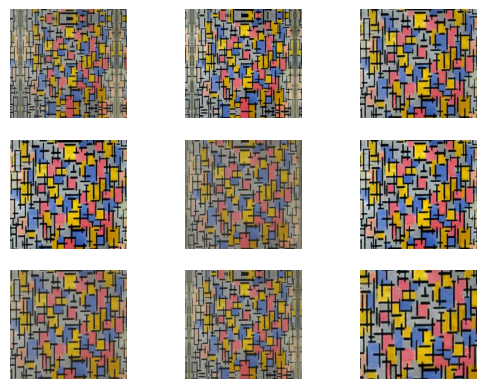

In [42]:
display_augmentation(train, data_augmentation)

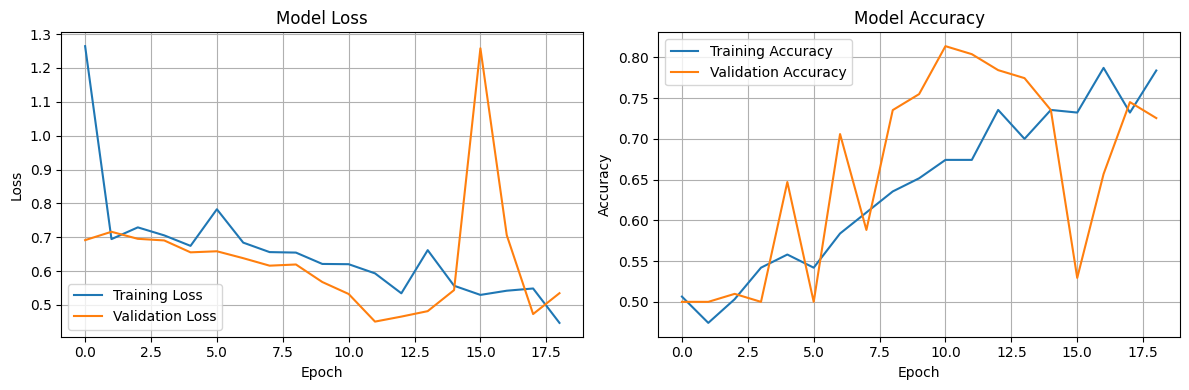

In [43]:
callbacks = [ModelCheckpoint(filepath="model_undersampled.keras", save_best_only=True, monitor="val_loss"), DynamicMetricsPlotCallback()
            ,EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)]
model = build_model(width, height, data_augmentation)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy", keras.metrics.Precision(), keras.metrics.Recall()])
history = model.fit(train, epochs=50, validation_data=val, callbacks=callbacks, verbose=0)

In [44]:
print_metrics(model, test)

Test Loss: 0.5238762497901917
Test Accuracy: 0.7352941036224365
Test Precision: 0.8157894611358643
Test Recall: 0.6078431606292725
